In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from xgboost import XGBClassifier

from sklearn.base import BaseEstimator
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
    TunedThresholdClassifierCV
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)

from naive_bayes import NaiveBayesClassifier

import pickle

In [2]:
x_train_scaled = pd.read_csv('cleaned/x_train.csv', header = None)
x_test_scaled = pd.read_csv('cleaned/x_test.csv', header = None)

y_train = pd.read_csv('cleaned/y_train.csv', header = None).values.ravel()
y_test = pd.read_csv('cleaned/y_test.csv', header = None).values.ravel()

In [3]:
# Raw Tweets for Naive Bayes
tweets = pd.read_csv('tweets/tweets_5k.csv')

train, test = train_test_split(tweets, test_size = 0.2, random_state = 1)

train.head()

,target,id,date,flag,user,text
1233,1,1558092957,Sun Apr 19 07:14:13 PDT 2009,NO_QUERY,zee_murmy,"Finally, rain."
1056,1,1989010164,Mon Jun 01 00:03:20 PDT 2009,NO_QUERY,keekz22,@renae_damia i love uuuuu bitch @theangelsanna...
1686,1,1693486925,Sun May 03 22:42:25 PDT 2009,NO_QUERY,InvoiceNinja,@boshemia *blushes*
187,0,1970576789,Sat May 30 04:25:14 PDT 2009,NO_QUERY,steadiman,Fun day in the sun at the airport shooting the...
3840,1,1992521980,Mon Jun 01 08:53:23 PDT 2009,NO_QUERY,BryceRaiff,following the twitter trend


## Helper functions

In [4]:
def rocs(model, name):
    ax = plt.axes()

    RocCurveDisplay.from_predictions(y_train,
                                     model.predict_proba(x_train_scaled)[:, 1],
                                     ax = ax,
                                     name = 'Train')

    RocCurveDisplay.from_predictions(y_test,
                                     model.predict_proba(x_test_scaled)[:, 1],
                                     ax = ax,
                                     name = 'Test')

    plt.title(f'{name} ROC')

    plt.show()

In [5]:
def confusion(preds, name):
    ConfusionMatrixDisplay.from_predictions(y_test, preds, cmap = 'Blues')

    plt.title(f'{name} Test Confusion Matrix')

    plt.show()

In [6]:
def scores_df(model, format = False):
    if isinstance(model, BaseEstimator):
        train_pred = model.predict(x_train_scaled)
        test_pred = model.predict(x_test_scaled)
    else:
        train_pred = model.predict(train)
        test_pred = model.predict(test)

    df =  pd.DataFrame({'Train': [accuracy_score(y_train, train_pred),
                                  precision_score(y_train, train_pred),
                                  recall_score(y_train, train_pred),
                                  f1_score(y_train, train_pred)],
                        'Test': [accuracy_score(y_test, test_pred),
                                 precision_score(y_test, test_pred),
                                 recall_score(y_test, test_pred),
                                 f1_score(y_test, test_pred)]})
    
    if format:
        df[['Train', 'Test']] = df[['Train', 'Test']].map('{:.1%}'.format)
        
    df.index = ['Accuracy', 'Precision', 'Recall', 'F1']

    return df

## XGBoost

In [7]:
# Create eval set for early stopping
x_eval, _, y_eval, _ = train_test_split(x_test_scaled,
                                        y_test,
                                        test_size = 0.2,
                                        stratify = y_test,
                                        random_state = 1)

In [8]:
xgb = XGBClassifier(random_state = 1,
                    early_stopping_rounds = 30)

xgb_grid = {'n_estimators': [200, 300, 400],
            'max_depth': [4, 6, 8],
            'learning_rate': [0.001, 0.01, 0.1],
            'subsample': [0.5, 0.75, 1.0],
            'reg_lambda': [0.01, 0.1, 1],
            'gamma': [0.01, 0.1, 1],
            'colsample_bytree': [0.5, 0.75, 1.0]}

xgb_gscv = GridSearchCV(xgb,
                        xgb_grid,
                        scoring = 'roc_auc',
                        cv = StratifiedKFold(3, shuffle = True, random_state = 1),
                        n_jobs = -1)

xgb_gscv.fit(x_train_scaled, y_train, eval_set = [(x_eval, y_eval)], verbose = False)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=30,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=N...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=1, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.75, 1.0],
                         'gamma': [0.01, 0.1, 1],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [200, 300, 400],
                         'reg_lambda': [0.01, 0.1, 1],
                         'subsample': [0.5, 0.75, 1.0]},
             scoring='roc_auc')

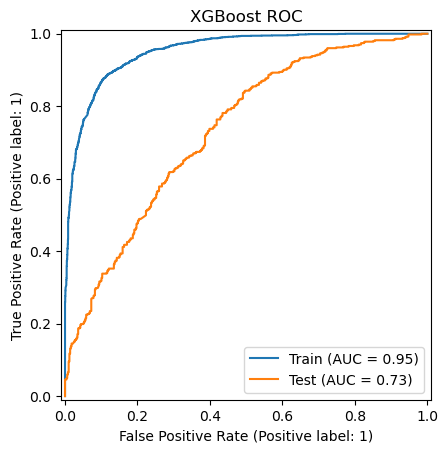

In [9]:
rocs(xgb_gscv, 'XGBoost')

### Threshold tuning

In [10]:
xgb_tuned = TunedThresholdClassifierCV(xgb_gscv.best_estimator_.set_params(early_stopping_rounds = None),
                                       cv = StratifiedKFold(5, shuffle = True, random_state = 1),
                                       random_state = 1,
                                       n_jobs = -1)

xgb_tuned.fit(x_train_scaled, y_train)

TunedThresholdClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                           estimator=XGBClassifier(base_score=None,
                                                   booster=None, callbacks=None,
                                                   colsample_bylevel=None,
                                                   colsample_bynode=None,
                                                   colsample_bytree=1.0,
                                                   device=None,
                                                   early_stopping_rounds=None,
                                                   enable_categorical=False,
                                                   eval_metric=None,
                                                   feature_types=None,
                                                   gamma=0.1, grow_policy=None,
                                                   importance_type=None,
                                                   interaction_constraints=None,
                                                   learning_rate=0.01,
                                                   max_bin=None,
                                                   max_cat_threshold=None,
                                                   max_cat_to_onehot=None,
                                                   max_delta_step=None,
                                                   max_depth=6, max_leaves=None,
                                                   min_child_weight=None,
                                                   missing=nan,
                                                   monotone_constraints=None,
                                                   multi_strategy=None,
                                                   n_estimators=400,
                                                   n_jobs=None,
                                                   num_parallel_tree=None,
                                                   random_state=1, ...),
                           n_jobs=-1, random_state=1)

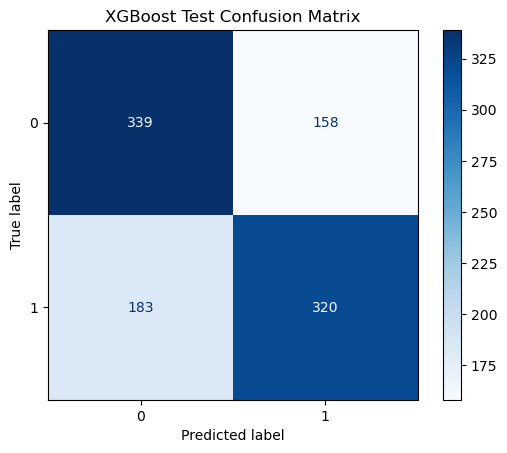

In [11]:
confusion(xgb_tuned.predict(x_test_scaled), 'XGBoost')

In [12]:
scores_df(xgb_tuned, format = True)

,Train,Test
Accuracy,88.4%,65.9%
Precision,88.6%,66.9%
Recall,88.3%,63.6%
F1,88.4%,65.2%


In [13]:
with open('models/xgb.pkl', 'wb') as file:
    pickle.dump(xgb_tuned, file)

## K-Nearest Neighbors (KNN)

In [14]:
knn = KNeighborsClassifier()

knn_grid = {'n_neighbors': np.arange(1, 100, 2)}

knn_gscv = GridSearchCV(knn,
                        knn_grid,
                        scoring = 'roc_auc',
                        cv = StratifiedKFold(5, shuffle = True, random_state = 1),
                        n_jobs = -1)

knn_gscv.fit(x_train_scaled, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99])},
             scoring='roc_auc')

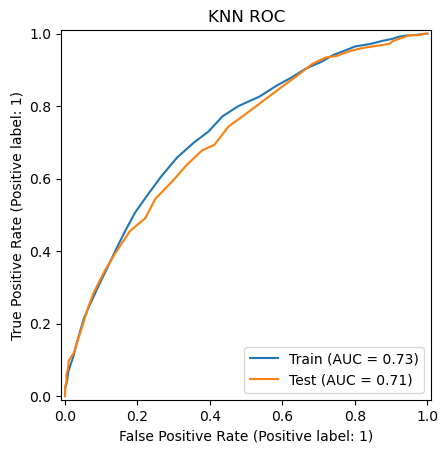

In [15]:
rocs(knn_gscv, 'KNN')

### Threshold tuning

In [16]:
knn_tuned = TunedThresholdClassifierCV(knn_gscv.best_estimator_,
                                       cv = StratifiedKFold(5, shuffle = True, random_state = 1),
                                       random_state = 1,
                                       n_jobs = -1)

knn_tuned.fit(x_train_scaled, y_train)

TunedThresholdClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                           estimator=KNeighborsClassifier(n_neighbors=67),
                           n_jobs=-1, random_state=1)

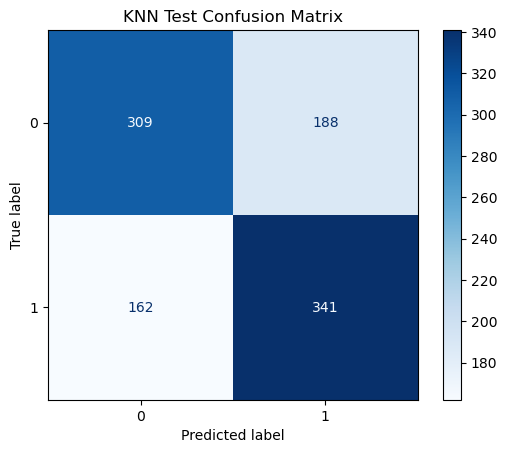

In [17]:
confusion(knn_tuned.predict(x_test_scaled), 'KNN')

In [18]:
scores_df(knn_tuned, format = True)

,Train,Test
Accuracy,67.2%,65.0%
Precision,66.4%,64.5%
Recall,69.9%,67.8%
F1,68.1%,66.1%


In [19]:
with open('models/knn.pkl', 'wb') as file:
    pickle.dump(knn_tuned, file)

## Bag-of-words Naive Bayes Classifier w/ Add-α Smoothing

In [20]:
def train_bayes(train, test, alpha):
    bayes = NaiveBayesClassifier(train, test)

    bayes.pretrain()

    bayes.train(alpha)

    return bayes

In [21]:
# Low-level cross-validation implementation for custom Naive Bayes classifier

def cross_val(X, y, alpha, k):
    cv = StratifiedKFold(k, shuffle = True, random_state = 1)

    scores = []

    for train_index, val_index in cv.split(X, y):

        train, val = X.iloc[train_index], X.iloc[val_index]

        bayes = train_bayes(train, val, alpha)

        scores.append(accuracy_score(val['target'], bayes.predict(val)))
    
    return np.mean(scores)

In [22]:
alphas = np.logspace(-1, 1, 10)

cross_val_scores = np.array([cross_val(train, train['target'], alpha, 5) for alpha in alphas])

best_alpha = alphas[cross_val_scores.argmax()]

bayes_tuned = train_bayes(train, test, best_alpha)

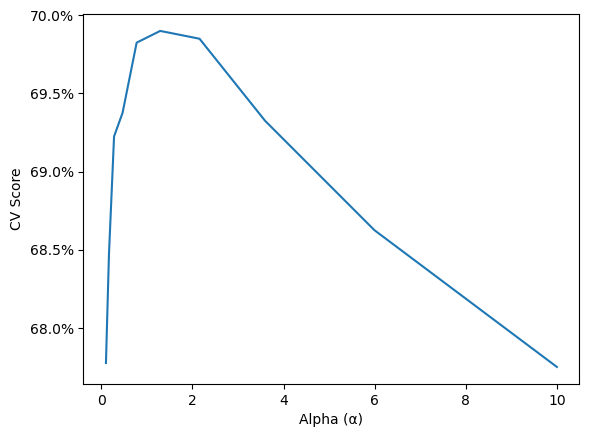

In [23]:
ax = sns.lineplot(x = alphas,
                  y = cross_val_scores)

plt.xlabel('Alpha (α)')
plt.ylabel('CV Score')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0, decimals = 1))

plt.show()

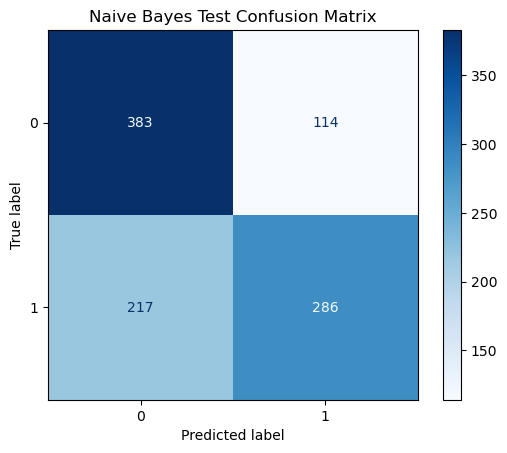

In [24]:
confusion(bayes_tuned.predict(test), 'Naive Bayes')

In [25]:
scores_df(bayes_tuned, format = True)

,Train,Test
Accuracy,94.5%,66.9%
Precision,97.4%,71.5%
Recall,91.3%,56.9%
F1,94.3%,63.3%


In [26]:
with open('models/bayes.pkl', 'wb') as file:
    pickle.dump(bayes_tuned, file)

## Linear Support Vector Machine (SVM)

In [27]:
svc = LinearSVC(dual = True,
                max_iter = int(1e8),
                random_state = 1)

svc_grid = {'C': np.logspace(-2, 2, 10)}

svc_gscv = GridSearchCV(svc,
                        svc_grid,
                        scoring = 'roc_auc',
                        cv = StratifiedKFold(5, shuffle = True, random_state = 1),
                        n_jobs = -1)

svc_gscv.fit(x_train_scaled, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=LinearSVC(dual=True, max_iter=100000000, random_state=1),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])},
             scoring='roc_auc')

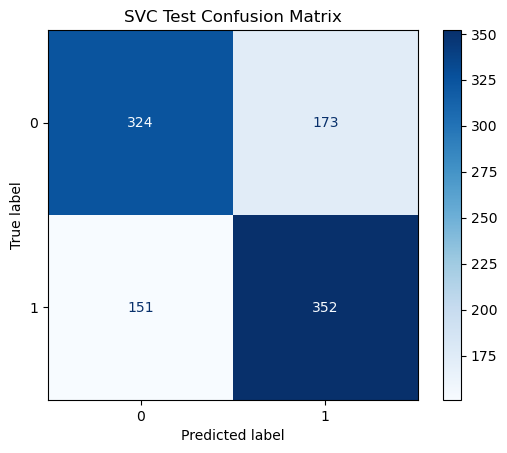

In [28]:
confusion(svc_gscv.predict(x_test_scaled), 'SVC')

In [29]:
scores_df(svc_gscv, format = True)

,Train,Test
Accuracy,67.3%,67.6%
Precision,66.8%,67.0%
Recall,69.0%,70.0%
F1,67.9%,68.5%


In [30]:
with open('models/svc.pkl', 'wb') as file:
    pickle.dump(svc_gscv, file)

## Random Forest

### Find sufficient number of trees using Out-of-Bag (OOB) score

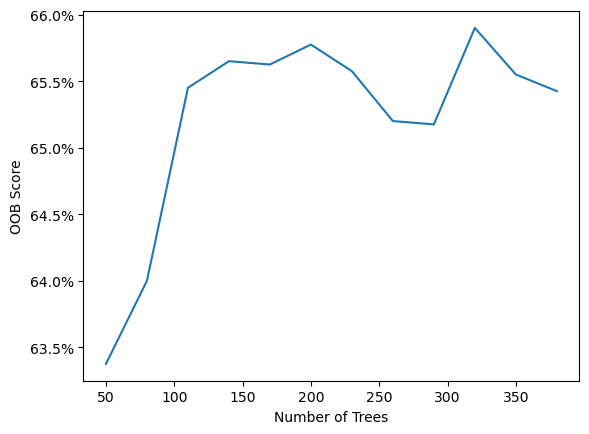

In [31]:
trees = np.arange(50, 401, 30)
scores = []

for tree in trees:
    rf = RandomForestClassifier(n_estimators = tree,
                                oob_score = True,
                                random_state = 1)
    
    rf.fit(x_train_scaled, y_train)

    scores.append(rf.oob_score_)

ax = sns.lineplot(x = trees,
                  y = scores)

plt.xlabel('Number of Trees')
plt.ylabel('OOB Score')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0, decimals = 1))

plt.show()

In [32]:
rf = RandomForestClassifier(n_estimators = 200,
                            random_state = 1)

rf_grid = [{'max_features': [0.5, 0.75, 1.0],
           'max_samples': [0.5, 0.75, 1.0],
           'bootstrap': [True]},
           {'max_features': [0.5, 0.75, 1.0],
           'bootstrap': [False]}]

rf_gscv = GridSearchCV(rf,
                       rf_grid,
                       scoring = 'roc_auc',
                       cv = StratifiedKFold(5, shuffle = True, random_state = 1),
                       n_jobs = -1)

rf_gscv.fit(x_train_scaled, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(n_estimators=200, random_state=1),
             n_jobs=-1,
             param_grid=[{'bootstrap': [True], 'max_features': [0.5, 0.75, 1.0],
                          'max_samples': [0.5, 0.75, 1.0]},
                         {'bootstrap': [False],
                          'max_features': [0.5, 0.75, 1.0]}],
             scoring='roc_auc')

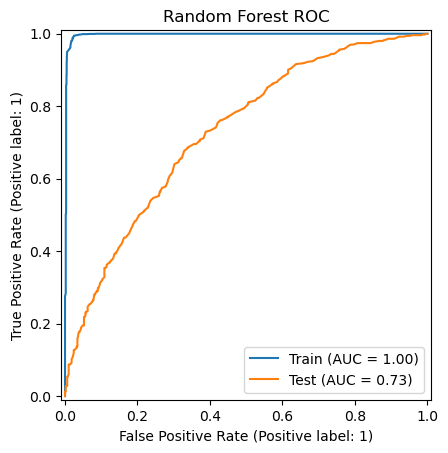

In [33]:
rocs(rf_gscv, 'Random Forest')

### Threshold tuning

In [34]:
rf_tuned = TunedThresholdClassifierCV(rf_gscv.best_estimator_,
                                      cv = StratifiedKFold(5, shuffle = True, random_state = 1),
                                      random_state = 1,
                                      n_jobs = -1)

rf_tuned.fit(x_train_scaled, y_train)

TunedThresholdClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                           estimator=RandomForestClassifier(max_features=0.75,
                                                            max_samples=0.5,
                                                            n_estimators=200,
                                                            random_state=1),
                           n_jobs=-1, random_state=1)

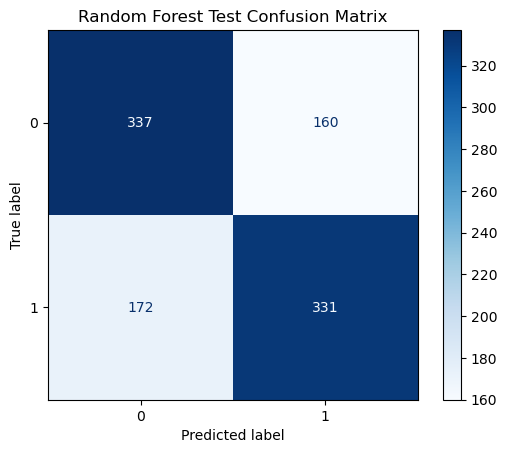

In [35]:
confusion(rf_tuned.predict(x_test_scaled), 'Random Forest')

In [36]:
scores_df(rf_tuned, format = True)

,Train,Test
Accuracy,98.4%,66.8%
Precision,97.7%,67.4%
Recall,99.2%,65.8%
F1,98.4%,66.6%


In [37]:
with open('models/rf.pkl', 'wb') as file:
    pickle.dump(rf_tuned, file)

## Logistic Regression w/ ElasticNet Regularization

In [38]:
Cs = np.logspace(-2, -1, 50)
l1_ratios = np.arange(0, 1.01, 0.1)

logit = LogisticRegressionCV(Cs = Cs,
                             l1_ratios = l1_ratios,
                             scoring = 'roc_auc',
                             penalty = 'elasticnet',
                             solver = 'saga',
                             random_state = 1,
                             n_jobs = -1)

logit.fit(x_train_scaled, y_train)

LogisticRegressionCV(Cs=array([0.01      , 0.01048113, 0.01098541, 0.01151395, 0.01206793,
       0.01264855, 0.01325711, 0.01389495, 0.01456348, 0.01526418,
       0.01599859, 0.01676833, 0.01757511, 0.0184207 , 0.01930698,
       0.0202359 , 0.02120951, 0.02222996, 0.02329952, 0.02442053,
       0.02559548, 0.02682696, 0.02811769, 0.02947052, 0.03088844,
       0.03237458, 0.03393222, 0.0355648 , 0.03727594, 0.0390694 ,
       0.04094915, 0.04291934, 0.04498433, 0.04714866, 0.04941713,
       0.05179475, 0.05428675, 0.05689866, 0.05963623, 0.06250552,
       0.06551286, 0.06866488, 0.07196857, 0.0754312 , 0.07906043,
       0.08286428, 0.08685114, 0.09102982, 0.09540955, 0.1       ]),
                     l1_ratios=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                     n_jobs=-1, penalty='elasticnet', random_state=1,
                     scoring='roc_auc', solver='saga')

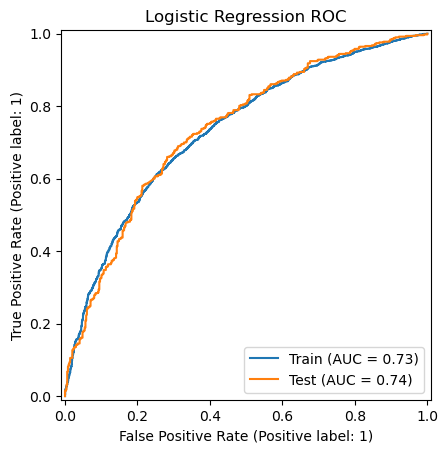

In [39]:
rocs(logit, 'Logistic Regression')

### Threshold tuning

In [40]:
logit_tuned = TunedThresholdClassifierCV(logit,
                                         cv = StratifiedKFold(5, shuffle = True, random_state = 1),
                                         random_state = 1,
                                         n_jobs = -1)

logit_tuned.fit(x_train_scaled, y_train)

TunedThresholdClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                           estimator=LogisticRegressionCV(Cs=array([0.01      , 0.01048113, 0.01098541, 0.01151395, 0.01206793,
       0.01264855, 0.01325711, 0.01389495, 0.01456348, 0.01526418,
       0.01599859, 0.01676833, 0.01757511, 0.0184207 , 0.01930698,
       0.0202359 , 0.02120951, 0.02222996, 0.02329952, 0.02442053,
       0.02559548,...
       0.04094915, 0.04291934, 0.04498433, 0.04714866, 0.04941713,
       0.05179475, 0.05428675, 0.05689866, 0.05963623, 0.06250552,
       0.06551286, 0.06866488, 0.07196857, 0.0754312 , 0.07906043,
       0.08286428, 0.08685114, 0.09102982, 0.09540955, 0.1       ]),
                                                          l1_ratios=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                                          n_jobs=-1,
                                                          penalty='elasticnet',
                                                          random_state=1,
                                                          scoring='roc_auc',
                                                          solver='saga'),
                           n_jobs=-1, random_state=1)

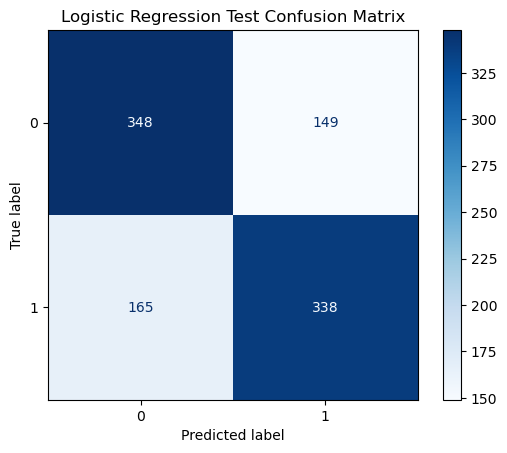

In [41]:
confusion(logit_tuned.predict(x_test_scaled), 'Logistic Regression')

In [42]:
scores_df(logit_tuned, format = True)

,Train,Test
Accuracy,67.7%,68.6%
Precision,68.1%,69.4%
Recall,66.6%,67.2%
F1,67.4%,68.3%


In [43]:
with open('models/logit.pkl', 'wb') as file:
    pickle.dump(logit_tuned, file)

## Performance comparison

In [44]:
def prep_scores(score_df, name):
    score_df = score_df['Test'].reset_index()
    
    score_df.columns = ['Metric', 'Score']

    score_df['Model'] = name

    return score_df

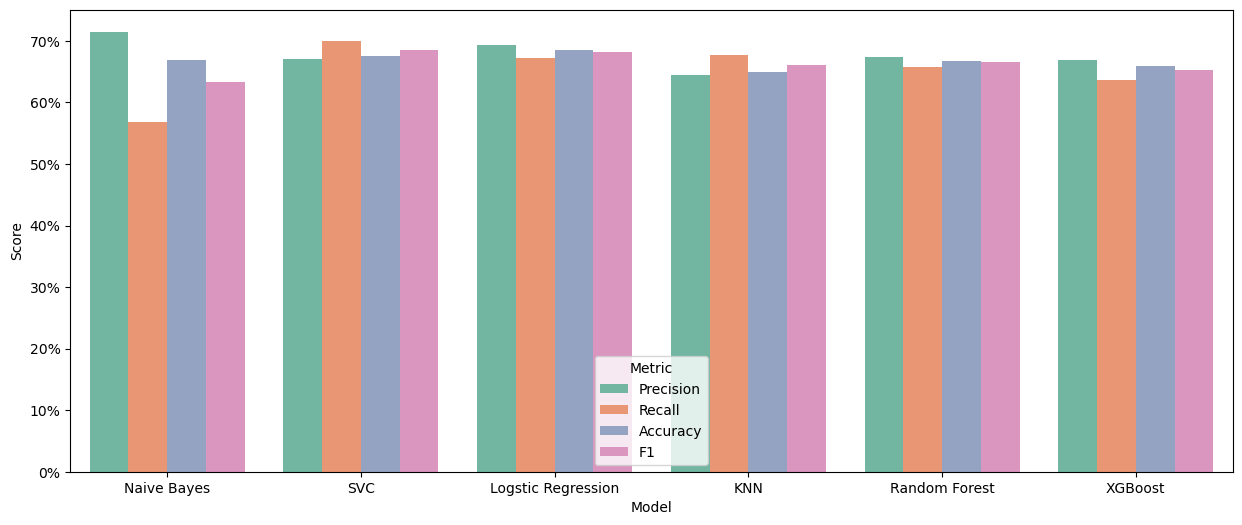

In [45]:
models = [rf_tuned, logit_tuned, knn_tuned, svc_gscv, xgb_tuned, bayes_tuned]
names = ['Random Forest', 'Logstic Regression', 'KNN', 'SVC', 'XGBoost', 'Naive Bayes']

scores = pd.concat([prep_scores(scores_df(model), name) for model, name in zip(models, names)]).sort_values(by = 'Score', ascending = False)

plt.figure(figsize = (15, 6))

ax = sns.barplot(x = 'Model',
                 y = 'Score',
                 hue = 'Metric',
                 data = scores,
                 palette = 'Set2')

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0, decimals = 0))

plt.show()